# clustered ROM

PCA embedding -> clustering -> sub-domain roms

In [1106]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({'font.size':16})

import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import pandas as pd
import sklearn.decomposition
import sklearn.preprocessing
import sklearn.mixture
import sklearn.metrics
import lalutils
import lalsimulation as lalsim
import phenom
import corner

<Figure size 640x480 with 0 Axes>

In [1107]:
# so we can specify minimum cluster size
from k_means_constrained import KMeansConstrained

In [1108]:
# ideas for classes

# class patch:
#     def __init__(self):
#         pass




# model = list(patch)

# model.get_patch(q=1, chi1=0.5, chi2=0.3)
# returns a patch that contains the above point
# 


# each patch knows how to predict the waveform for the parameters given

# for amp, phase, prec-angles could use the same patches to reduce computational cost
# or if not appropriate can use different patches for each model

In [1109]:
def metrics_mean_percentage_error(y_true, y_pred):
    """
    y_true, y_pred have shapes of (N_samples, N_dim) and we average over N_dim
    and return a vector of length N_samples
    """
    return np.mean((y_pred - y_true)/y_true * 100, axis=1)

def metrics_mean_abs_percentage_error(y_true, y_pred):
    """
    y_true, y_pred have shapes of (N_samples, N_dim) and we average over N_dim
    and return a vector of length N_samples
    """
    return np.mean(np.abs(y_pred - y_true)/y_true * 100, axis=1)

In [1110]:
def resample(x, y, new_x):
    return IUS(x,y)(new_x)

In [1111]:
def generate_data(q, chi1, chi2, m_total=100, deltaT=1 / 4096, f_min=10, approximant=lalsim.SEOBNRv4, t_min=-500, t_max=100, dt_M=0.75):
    """
    generate a single waveform
    """
    m1, m2 = phenom.m1_m2_M_q(m_total, q)
    eta = phenom.eta_from_q(q)
    p=lalutils.gen_td_wf_params(
        m1=m1,
        m2=m2,
        S1z=chi1,
        S2z=chi2,
        deltaT=deltaT,
        f_min=f_min,
        inclination=np.pi/3,
        approximant=approximant,
    )

    t, amp, phi = lalutils.gen_td_wf(p, t_min=None, t_max=None)

    # scale amp by eta
    amp = amp / eta

    assert t[0] <= t_min, 'probably need a lower f_min'
    assert t[-1] >= t_max, 'use lower t_max'

    new_t = np.arange(t_min, t_max, dt_M)
    amp = resample(t, amp, new_t)
    phi = resample(t, phi, new_t)

    return new_t, amp, phi

In [1112]:
def generate_data_loop(qs, chi1s, chi2s, **kwargs):
    """
    loop over and generate many waveforms
    """
    ts=[]
    amps=[]
    phis=[]
    for i in range(len(qs)):
        q=qs[i]
        chi1=chi1s[i]
        chi2=chi2s[i]
        t_, amp_, phi_ = generate_data(q, chi1, chi2, **kwargs)
        
        ts.append(t_)
        amps.append(amp_)
        phis.append(phi_)

    times = ts[0]
    amps = np.array(amps)
    phis = np.array(phis)
    return times, amps, phis

In [1113]:
# MSE = sklearn.metrics.mean_squared_error(y_actual, y_predicted)
# metrics_percentage_error(y_true, y_pred)

In [1114]:
# def compute_pca(X, n_components, max_variance=None):
#     pca = sklearn.decomposition.PCA(n_components=n_components)
#     pca.fit(X)

#     if max_variance != None:
#         variances = pca.explained_variance_ratio_.cumsum()
#         n_components_keep = len(variances[variances <= max_variance])
#         # inefficient but not sure best way to hack it
#         pca = sklearn.decomposition.PCA(n_components=n_components_keep)
#         pca.fit(X)

#     coeffs = pca.transform(X)
#     columns = [i for i in range(coeffs.shape[1])]
#     coeffs = pd.DataFrame(coeffs, columns=columns)

#     return pca, coeffs

In [1115]:
def compute_pca(X, n_components, max_percentage_error=5):
    pca = sklearn.decomposition.PCA(n_components=n_components)
    pca.fit(X)

    coeffs = pca.transform(X)

    # loop over predictions with increasing basis size
    # find the first instance where the error is less than tolerance
    basis_sizes = np.arange(1, n_components+1)
    max_mean_percentage_errors = []
    for basis_size in basis_sizes:
        X_pred = np.dot(coeffs[:,:basis_size], pca.components_[:basis_size])
        # averaged over time
        # mean_percentage_errors = metrics_mean_percentage_error(X, X_pred)
        # mean_percentage_errors = metrics_mean_abs_percentage_error(X, X_pred)
        mean_percentage_errors = sklearn.metrics.mean_squared_error(X, X_pred)
        # now take the max error over samples
        max_mean_percentage_errors.append(np.max(mean_percentage_errors))
        # max_mean_percentage_errors.append(np.mean(mean_percentage_errors))

    max_mean_percentage_errors = np.array(max_mean_percentage_errors)
    # plt.plot(basis_sizes, max_mean_percentage_errors)
    basis_sizes_tol = basis_sizes[max_mean_percentage_errors <= max_percentage_error][0]
    # print(basis_sizes_tol)

    pca = sklearn.decomposition.PCA(n_components=basis_sizes_tol)
    pca.fit(X)

    coeffs = pca.transform(X)
    columns = [i for i in range(coeffs.shape[1])]
    coeffs = pd.DataFrame(coeffs, columns=columns)

    return pca, coeffs

In [1116]:
def compute_clusters(parameters, X, method, method_kwargs):
    """
    parameters: data frame of physical parameters so we can assign cluster label


    KMeansConstrained: method_kwargs=dict(n_clusters=n_clusters,size_min=size_min)
    """
    assert method in ['gmm', 'kmeans', 'KMeansConstrained'], 'unknown method'
    parameters = parameters.copy()

    if method == 'gmm':
        gmm = sklearn.mixture.GaussianMixture(**method_kwargs).fit(X)
        labels = gmm.predict(X)
        unique_labels = np.unique(labels)
        parameters['cluster'] = labels
        
        return gmm, labels, unique_labels, parameters

    elif method == 'kmeans':
        kmeans = sklearn.cluster.KMeans(**method_kwargs).fit(X)
        labels = kmeans.labels_
        unique_labels = np.unique(labels)
        parameters['cluster'] = labels
        
        return kmeans, labels, unique_labels, parameters

    elif method =='KMeansConstrained':
        kmeans = KMeansConstrained(**method_kwargs).fit(X)
        labels = kmeans.labels_
        unique_labels = np.unique(labels)
        parameters['cluster'] = labels
        
        return kmeans, labels, unique_labels, parameters

In [1117]:
def model_clusters(X, gmm_kwargs):
    gmm = sklearn.mixture.GaussianMixture(**gmm_kwargs).fit(X)
    return gmm

In [1118]:
def decompose_and_cluster(parameters, X, pca_kwargs, cluster_method, cluster_method_kwargs):
    pca, coeffs = compute_pca(X, **pca_kwargs)

    cluster_clf, labels, unique_labels, parameters = compute_clusters(parameters, coeffs, cluster_method, cluster_method_kwargs)

    return pca, coeffs, cluster_clf, labels, unique_labels, parameters

In [1119]:
def seed_random_samples(n_samples):
    qs = np.random.uniform(1, 20, n_samples)
    chi1s = np.random.uniform(-1, 1, n_samples)
    chi2s = np.random.uniform(-1, 1, n_samples)

    return pd.DataFrame({'q':qs, 'chi1':chi1s, 'chi2':chi2s})

In [1120]:
seed_parameters = seed_random_samples(5000)

In [1121]:
features = list(seed_parameters.columns)
features

['q', 'chi1', 'chi2']

In [1122]:
seed_parameters.head()

q      chi1      chi2
0   1.993791 -0.073649  0.978030
1   7.796260  0.837211 -0.208699
2  17.055206 -0.460855 -0.363694
3   7.261408  0.189285 -0.202340
4  15.452087 -0.825960 -0.699919

In [1123]:
times, amps, phis = generate_data_loop(seed_parameters['q'], seed_parameters['chi1'], seed_parameters['chi2'], approximant=lalsim.IMRPhenomT)

In [1124]:
X = amps
del amps
del phis

In [1125]:
times.shape

(800,)

In [1126]:
seed_parameters.shape

(5000, 3)

In [1127]:
X.shape

(5000, 800)

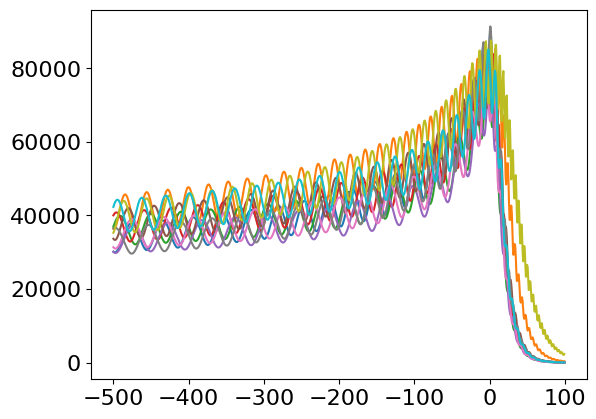

In [1128]:
plt.plot(times, X[:10].T);

In [1129]:
l0_scaler = sklearn.preprocessing.StandardScaler()
X_prime = l0_scaler.fit_transform(X)

In [1130]:
# pca, coeffs, cluster_clf, labels, unique_labels, parameters = decompose_and_cluster(seed_parameters, X_prime, pca_kwargs={'n_components':50, 'max_variance':0.9999}, cluster_method='kmeans', cluster_method_kwargs=dict(n_clusters=5, n_init='auto'))

# pca, coeffs, cluster_clf, labels, unique_labels, parameters = decompose_and_cluster(seed_parameters, X_prime, pca_kwargs={'n_components':50, 'max_variance':0.9999}, cluster_method='KMeansConstrained', cluster_method_kwargs=dict(n_clusters=10, size_min=100))

pca, coeffs, cluster_clf, labels, unique_labels, parameters = decompose_and_cluster(seed_parameters, X_prime, pca_kwargs={'n_components':50, 'max_percentage_error':0.05}, cluster_method='KMeansConstrained', cluster_method_kwargs=dict(n_clusters=50, size_min=100))

In [1131]:
pca.n_components_

33

In [1132]:
pca.explained_variance_ratio_.sum()

0.950180121317739

In [1133]:
idx = np.random.randint(0, len(X_prime))

plt.figure()
plt.plot(X_prime[idx])
plt.plot(np.dot(coeffs.values[idx][None,:], pca.components_)[0])

mse = sklearn.metrics.mean_squared_error(X_prime[idx], np.dot(coeffs.values[idx][None,:], pca.components_)[0])
plt.title(f"{mse:.5f}")


plt.figure()
plt.plot(X[idx])
plt.plot(l0_scaler.inverse_transform(np.dot(coeffs.values[idx][None,:], pca.components_))[0])

In [1134]:
parameters

q      chi1      chi2  cluster
0      1.993791 -0.073649  0.978030       48
1      7.796260  0.837211 -0.208699       22
2     17.055206 -0.460855 -0.363694        4
3      7.261408  0.189285 -0.202340       49
4     15.452087 -0.825960 -0.699919        9
...         ...       ...       ...      ...
4995  16.869213  0.039056 -0.855860       31
4996  16.439572  0.263027 -0.487221       32
4997   7.856825 -0.205932 -0.892932       30
4998  18.643584  0.264596  0.904674       38
4999   5.217296  0.801929  0.065899       32

[5000 rows x 4 columns]

In [1135]:
parameters['cluster'].value_counts()

cluster
48    100
15    100
12    100
10    100
11    100
8     100
45    100
29    100
43    100
39    100
25    100
5     100
20    100
22    100
6     100
2     100
34    100
31    100
26    100
44    100
37    100
14    100
41    100
3     100
30    100
46    100
19    100
17    100
4     100
49    100
9     100
18    100
21    100
7     100
28    100
32    100
13    100
23    100
40    100
38    100
16    100
0     100
27    100
24    100
47    100
1     100
33    100
35    100
36    100
42    100
Name: count, dtype: int64

In [1136]:
coeffs

0         1         2         3         4         5         6   \
0    -10.768133  1.551003 -6.086485 -3.946628 -6.451418 -2.495923  5.538414   
1     25.674602 -0.791093 -4.294119 -1.337490 -0.043679  0.233390 -0.460182   
2    -11.469249 -0.424307  4.879964 -0.512776  5.838441 -2.287891 -7.205136   
3     -1.766161 -1.951902 -1.448557  1.133071  1.015657  3.826565  4.949601   
4    -22.507481  3.009206  2.013549  8.533080 -0.011899 -5.926041  2.343479   
...         ...       ...       ...       ...       ...       ...       ...   
4995   4.021375 -4.347267  3.213434 -0.500435  1.538611  2.989520 -0.399567   
4996  12.551226 -6.324676  2.669090 -0.037518 -0.684871 -0.707032 -1.512272   
4997 -12.607874  0.536470  2.287853 -5.526189 -4.340722 -3.981603  5.258181   
4998  15.686384 -7.316467  3.586303  0.832818  0.929948  1.093628  0.275059   
4999  14.601881  0.119121 -6.756851 -2.418700 -1.059884 -1.019224 -1.979183   

            7         8         9   ...        23        24        25  \
0    -2.091258 -4.505787  0.940336  ...  1.266397  1.527784 -0.063165   
1     0.564221 -0.595143 -0.990027  ...  2.970138 -1.835269 -0.238716   
2     4.919154  1.996511  3.317491  ... -0.334400  0.180694 -0.462661   
3     5.191547 -1.313826  0.641351  ...  1.035308 -0.459224  1.266754   
4    -2.660757  0.783389  2.335366  ... -1.434168 -0.870087 -0.430441   
...        ...       ...       ...  ...       ...       ...       ...   
4995  2.195002 -2.674700  2.521748  ...  0.301740  0.274911 -0.208541   
4996 -0.011846 -0.360374  3.353128  ... -4.931432 -0.077069 -5.101842   
4997 -2.607325 -2.905001  0.148714  ...  0.318197 -0.105535  0.603732   
4998  1.844408 -1.388939 -1.028108  ...  8.548635 -1.011170  1.181236   
4999 -1.096042 -1.995241  0.387508  ... -2.224443  1.069973  4.520284   

            26        27        28        29        30        31        32  
0     0.552033  1.291343  0.245172  2.115099  0.204257 -0.041078  1.020773  
1    -2.139879  1.760697  1.438440 -0.401467 -4.976325 -7.758772  0.124199  
2    -0.529857 -0.062302 -0.357862 -0.460823 -0.218187 -0.211558  0.009685  
3    -0.035684 -0.593914  0.699450  0.555490  0.385494  0.661958 -0.240390  
4    -1.855955 -0.746635 -0.384916 -0.503340 -1.004086 -0.081549 -1.711053  
...        ...       ...       ...       ...       ...       ...       ...  
4995  1.621597  0.498304  0.459179  0.821331  0.436865  0.326059  0.958455  
4996  1.583957  0.146373  0.485462  1.447503 -0.128238  0.479918  0.678684  
4997  1.018228  0.102133  0.096950 -0.254819  0.357874 -0.051059  0.662110  
4998 -0.643538  3.112036  0.103431  1.997606  0.799623 -0.028922  0.463103  
4999 -2.058577  3.115549  3.268548 -3.289169  0.982959  4.220161 -5.348570  

[5000 rows x 33 columns]

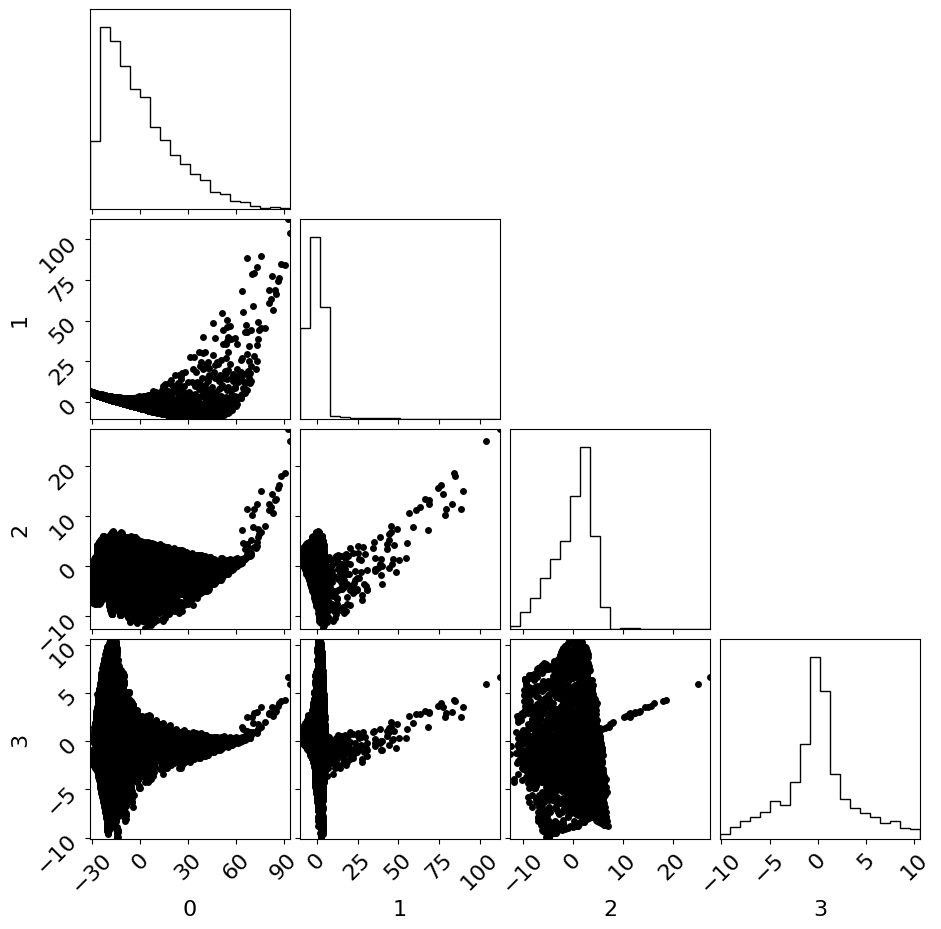

In [1137]:
# restrict size of corner
if coeffs.shape[1] > 4:
    dims_to_plot = 4
else:
    dims_to_plot = coeffs.shape[1]
corner.corner(coeffs.values[:,:dims_to_plot], labels=coeffs.columns[:dims_to_plot], plot_contours=False, plot_density=False, data_kwargs={'ms':5, 'alpha':1});

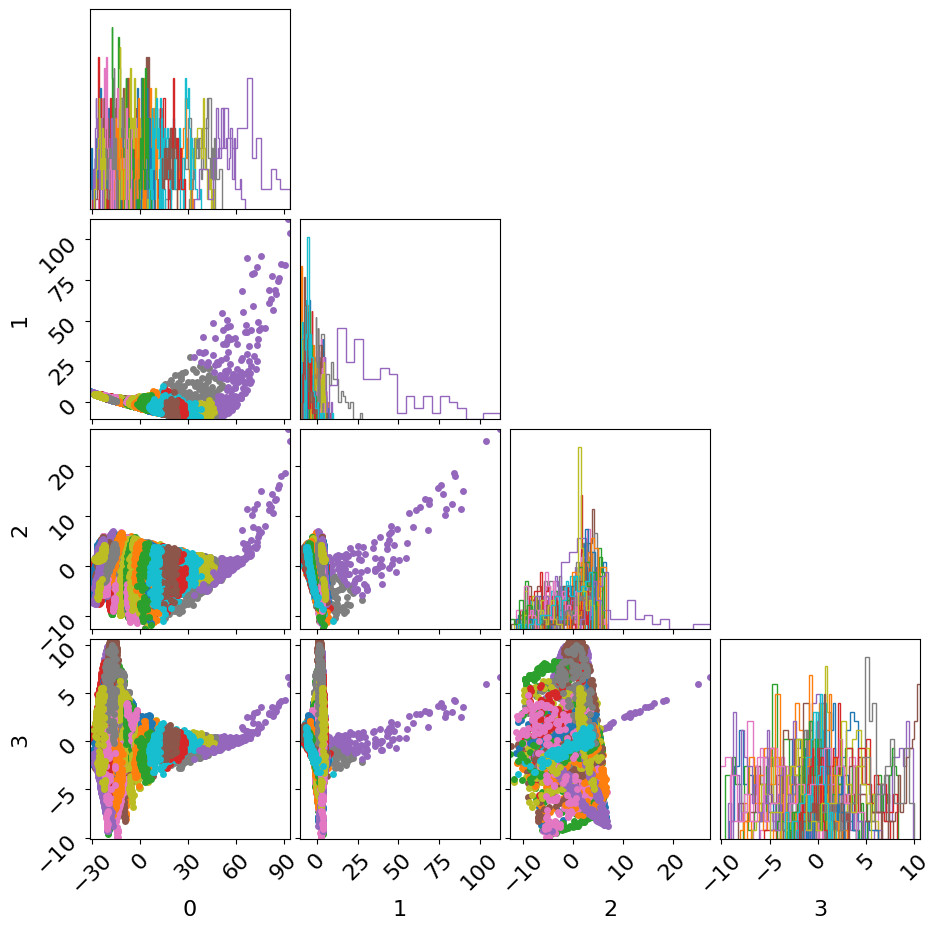

In [1138]:
for i, cluster in enumerate(parameters['cluster'].unique()):
    index = parameters[parameters['cluster']==cluster].index
    to_plot = coeffs.iloc[index].values[:,:dims_to_plot]
    if i == 0:
        fig = corner.corner(to_plot, color=f'C{i}', labels=coeffs.columns[:dims_to_plot], plot_contours=False, plot_density=False, data_kwargs={'ms':5, 'alpha':1})
    else:
        corner.corner(to_plot, color=f'C{i}', labels=coeffs.columns[:dims_to_plot], plot_contours=False, plot_density=False, data_kwargs={'ms':5, 'alpha':1}, fig=fig)

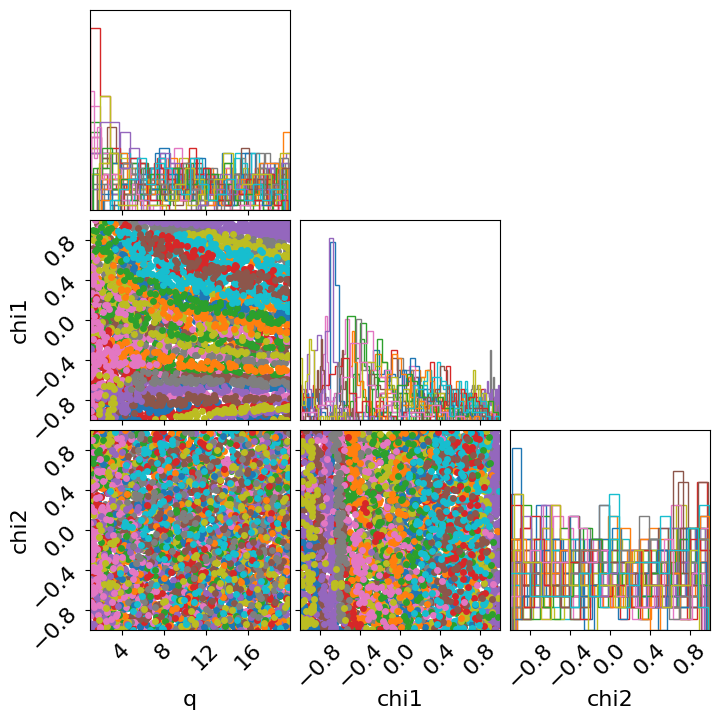

In [1139]:
for i, cluster in enumerate(parameters['cluster'].unique()):
    to_plot = parameters[parameters['cluster']==cluster][features]
    if i == 0:
        fig = corner.corner(to_plot, color=f'C{i}', labels=features, plot_contours=False, plot_density=False, data_kwargs={'ms':5, 'alpha':1})
    else:
        corner.corner(to_plot, color=f'C{i}', labels=features, plot_contours=False, plot_density=False, data_kwargs={'ms':5, 'alpha':1}, fig=fig)

In [1140]:
parameters

q      chi1      chi2  cluster
0      1.993791 -0.073649  0.978030       48
1      7.796260  0.837211 -0.208699       22
2     17.055206 -0.460855 -0.363694        4
3      7.261408  0.189285 -0.202340       49
4     15.452087 -0.825960 -0.699919        9
...         ...       ...       ...      ...
4995  16.869213  0.039056 -0.855860       31
4996  16.439572  0.263027 -0.487221       32
4997   7.856825 -0.205932 -0.892932       30
4998  18.643584  0.264596  0.904674       38
4999   5.217296  0.801929  0.065899       32

[5000 rows x 4 columns]

In [1141]:
parameters[parameters['cluster']==cluster]

q      chi1      chi2  cluster
194   11.033137  0.383944  0.689946       42
197    4.640600  0.738017  0.043220       42
234    5.115630  0.705602 -0.998635       42
288    9.179405  0.420021  0.027994       42
472    8.183191  0.434370  0.845534       42
...         ...       ...       ...      ...
4583   6.511288  0.632754 -0.075208       42
4639   8.791976  0.350939  0.899292       42
4643   7.819235  0.472966  0.792912       42
4721  11.365535  0.385574 -0.857051       42
4924  14.599683  0.206908 -0.227987       42

[100 rows x 4 columns]

In [1142]:
l0_cluster_models={}
gmm_kwargs = dict(n_components=2)
for cluster in parameters['cluster'].unique():
    X_cluster = parameters[parameters['cluster']==cluster][features]
    l0_cluster_models[cluster] = model_clusters(X_cluster, gmm_kwargs)

In [1143]:
# need to sample ensure boundaries are satisfied

In [1144]:
def constrained_sampler(gmm, n_samples, over_sample_factor=1.3, q_bounds=(1, 20), chi1_bounds=(-1, 1), chi2_bounds=(-1, 1)):
    """
    over_sample_factor: because we constrain the samples we have to over sample and hope that we get the desired number of `n_samples`
    """
    n_samples_over = int(n_samples*over_sample_factor)
    samples = gmm.sample(n_samples_over)[0]
    mask = (
        (samples[:,0] >= q_bounds[0]) & (samples[:,0] <= q_bounds[1])
    &   (samples[:,1] >= chi1_bounds[0]) & (samples[:,1] <= chi1_bounds[1])
    &   (samples[:,2] >= chi2_bounds[0]) & (samples[:,2] <= chi2_bounds[1])
        )

    assert mask.sum() >= n_samples, f'got {mask.sum()} samples, not enough samples, try again  or increase over_sample_factor'
    
    return samples[mask][:n_samples]

In [1145]:
constrained_sampler(l0_cluster_models[0], 1000).shape

(1000, 3)

In [1146]:
for i, cluster in enumerate(parameters['cluster'].unique()):
    # to_plot = l0_cluster_models[cluster].sample(1000)[0]
    to_plot = constrained_sampler(l0_cluster_models[cluster], 1000)
    print(to_plot.shape)
    if i == 0:
        fig = corner.corner(to_plot, color=f'C{i}', labels=features, plot_contours=False, plot_density=False, data_kwargs={'ms':5, 'alpha':1})
    else:
        corner.corner(to_plot, color=f'C{i}', labels=features, plot_contours=False, plot_density=False, data_kwargs={'ms':5, 'alpha':1}, fig=fig)

(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)


In [1147]:
# cluster_clf.sample(100)

In [1148]:
constrained_sampler(l0_cluster_models[cluster], 10000)

array([[ 8.9680141 ,  0.30953437,  0.67101896],
       [ 4.65769029,  0.70185902,  0.2319709 ],
       [ 6.99302743,  0.58804726, -0.96983014],
       ...,
       [11.72109386,  0.34092428, -0.15124067],
       [12.10011662,  0.35141404, -0.36452114],
       [ 9.25789803,  0.35321177,  0.25463305]])

In [1149]:
len(l0_cluster_models.keys())

50

In [1150]:
l0_cluster_models.keys()

dict_keys([48, 22, 4, 49, 9, 18, 21, 7, 28, 32, 13, 23, 40, 38, 16, 0, 27, 24, 47, 1, 33, 35, 36, 17, 19, 46, 30, 12, 10, 11, 8, 45, 29, 43, 39, 25, 5, 15, 20, 6, 2, 34, 31, 26, 44, 37, 14, 41, 3, 42])

In [1151]:
# don't generate same data, need to sample new parameters from clusters and then generate new data
# also create a new standard scaler for this cluster

l1_data={}
# loop over clusters and generate new waveforms and make a new standard scaler

# for cluster in l0_cluster_models.keys():
# just look at 0 cluster for testing
for cluster in [0,1,2,3,4]:
    print(cluster)
    qs, chi1s, chi2s = constrained_sampler(l0_cluster_models[cluster], 1000).T
    name=f'cluster_{cluster}'
    l1_data[name]={}
    l1_data[name]['parameters'] = pd.DataFrame({'q':qs, 'chi1':chi1s, 'chi2':chi2s})
    p = l1_data[name]['parameters']
    l1_data[name]['times'], l1_data[name]['amps'], l1_data[name]['phis'] = generate_data_loop(p['q'], p['chi1'], p['chi2'], approximant=lalsim.IMRPhenomT)

    l1_data[name]['scaler'] = sklearn.preprocessing.StandardScaler()
    l1_data[name]['X'] = l1_data[name]['amps'].copy()
    l1_data[name]['X_prime'] = l1_data[name]['scaler'].fit_transform(l1_data[name]['X'])

0
1
2
3
4


In [1152]:
l1_data.keys()

dict_keys(['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])

In [1153]:
l1_data['cluster_0'].keys()

dict_keys(['parameters', 'times', 'amps', 'phis', 'scaler', 'X', 'X_prime'])

In [1154]:
l0_cluster_models.keys()

dict_keys([48, 22, 4, 49, 9, 18, 21, 7, 28, 32, 13, 23, 40, 38, 16, 0, 27, 24, 47, 1, 33, 35, 36, 17, 19, 46, 30, 12, 10, 11, 8, 45, 29, 43, 39, 25, 5, 15, 20, 6, 2, 34, 31, 26, 44, 37, 14, 41, 3, 42])

In [1155]:
# for cluster in l0_cluster_models.keys():
# just look at 0 cluster for testing
for cluster in [0]:
    name=f'cluster_{cluster}'
    # l1_data[name]['pca'], l1_data[name]['coeffs'], l1_data[name]['cluster_clf'], l1_data[name]['labels'], l1_data[name]['unique_labels'], l1_data[name]['parameters'] = decompose_and_cluster(l1_data[name]['parameters'], l1_data[name]['X_prime'], pca_kwargs={'n_components':50, 'max_variance':0.9999}, cluster_method='kmeans', cluster_method_kwargs=dict(n_clusters=5, n_init='auto'))
    l1_data[name]['pca'], l1_data[name]['coeffs'], l1_data[name]['cluster_clf'], l1_data[name]['labels'], l1_data[name]['unique_labels'], l1_data[name]['parameters'] = decompose_and_cluster(l1_data[name]['parameters'], l1_data[name]['X_prime'], pca_kwargs={'n_components':50, 'max_percentage_error':0.005}, cluster_method='KMeansConstrained', cluster_method_kwargs=dict(n_clusters=10, size_min=100))

In [1156]:
# for cluster in l0_cluster_models.keys():
for cluster in [0]:
    name=f'cluster_{cluster}'
    print(l1_data[name]['pca'].n_components_)
    print(l1_data[name]['pca'].explained_variance_ratio_.sum())

12
0.996167951916633


In [1157]:
l1_data[name]['pca']

PCA(n_components=12)

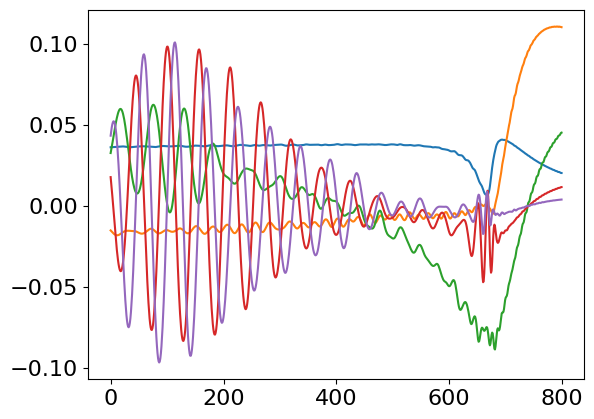

In [1158]:
plt.plot(pca.components_[:5].T);

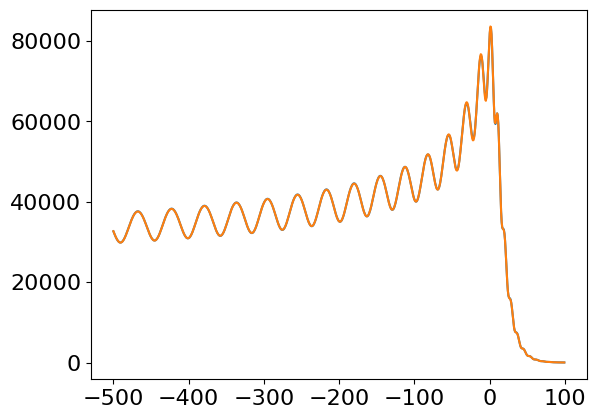

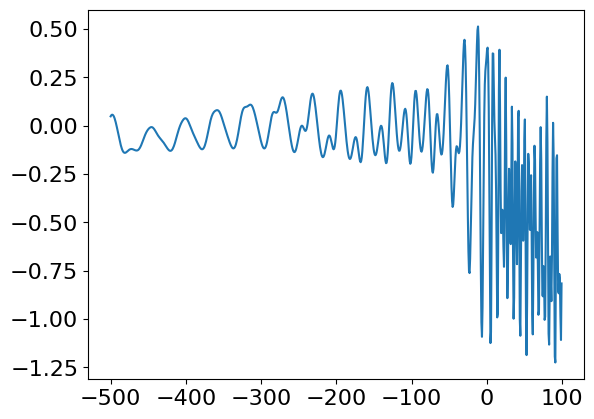

In [1159]:
cluster = 0
name=f'cluster_{cluster}'
idx = np.random.randint(0, len(l1_data[name]['X_prime']))

x__ = l1_data[name]['X'][idx]
xp__ = l1_data[name]['X_prime'][idx]
x2__ = np.dot(l1_data[name]['coeffs'].values[idx][None,:], l1_data[name]['pca'].components_)[0]
x3__ = l1_data[name]['scaler'].inverse_transform(x2__[None,:])[0]

plt.figure()
plt.plot(times, xp__)
plt.plot(times, x2__)
# plt.xlim(0, 100)

mse = sklearn.metrics.mean_squared_error(xp__, x2__)
plt.title(f"{mse:.5f}")


plt.figure()
plt.plot(times, x__)
plt.plot(times, x3__)
# plt.xlim(0, 100)


plt.figure()
plt.plot(times,(x3__-x__)/x__ * 100)
# plt.xlim(0, 100)

# greedy RB compared to PCA

In [1160]:
import rompy as rp

In [1161]:
integration = rp.Integration([times[0], times[-1]], num=len(times), rule='trapezoidal')
x = integration.nodes

In [1384]:
l1_data.keys()

dict_keys(['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])

In [1632]:
training = X_prime
# training = X
this_scaler = l0_scaler


# name = f'cluster_1'
# training = l1_data[name]['X_prime']
# this_scaler = l1_data[name]['scaler']

In [1633]:
rb = rp.ReducedBasis(integration)

In [1634]:
rb.make(training, np.random.randint(0, len(training)), 1e-3, verbose=True, rel=True)

('\nStep', '\t', 'Error')
(1, '\t', 1.0)
(2, '\t', 0.9999816625730471)
(3, '\t', 0.12375811869539699)
(4, '\t', 0.06474362840204109)
(5, '\t', 0.05308016999457988)
(6, '\t', 0.02856051916587055)
(7, '\t', 0.025358196348710275)
(8, '\t', 0.023952312050953523)
(9, '\t', 0.022643267500583635)
(10, '\t', 0.020486695482924203)
(11, '\t', 0.020180494292547792)
(12, '\t', 0.019796743119624975)
(13, '\t', 0.01950559297147743)
(14, '\t', 0.017486872000641328)
(15, '\t', 0.016758780691582313)
(16, '\t', 0.016634683546702958)
(17, '\t', 0.016300669172200282)
(18, '\t', 0.015508364775486925)
(19, '\t', 0.014950182775646895)
(20, '\t', 0.014752352546888843)
(21, '\t', 0.014575497122509521)
(22, '\t', 0.01421550624221218)
(23, '\t', 0.013931759412428087)
(24, '\t', 0.013505888372138078)
(25, '\t', 0.012647444010659623)
(26, '\t', 0.012475518309613668)
(27, '\t', 0.012387544994269157)
(28, '\t', 0.011778434290623738)
(29, '\t', 0.011692626206265877)
(30, '\t', 0.011680051836768896)
(31, '\t', 0.01162

In [1635]:
rb.size

71

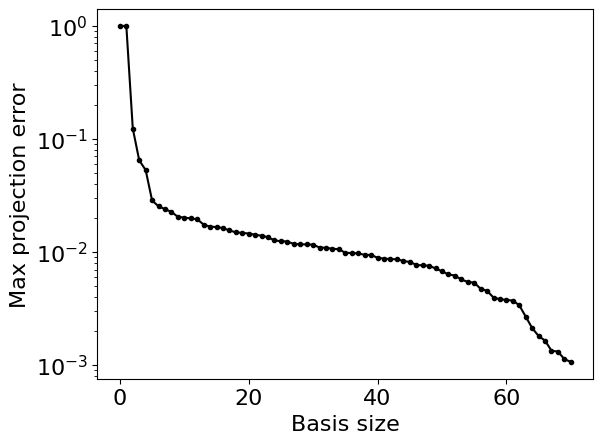

In [1636]:

plt.semilogy(rb.errors/rb.errors[0], 'k.-');
plt.xlabel('Basis size')
plt.ylabel('Max projection error')
plt.show()

In [1637]:
for i in range(3):
    plt.plot(x, rb.basis[i])
plt.title('rb')

Text(0.5, 1.0, 'rb')

Text(0.5, 1.0, 'pca')

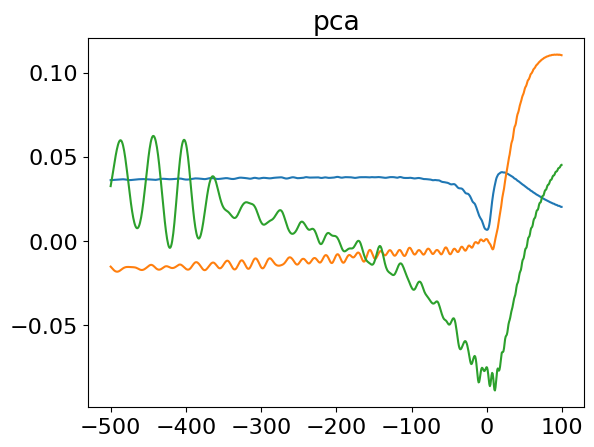

In [1638]:
for i in range(3):
    plt.plot(x, pca.components_[i])
plt.title("pca")

In [1639]:
rb.alpha.shape

(71, 5000)

In [1640]:
rb.basis.shape

(71, 800)

In [1641]:
rb.alpha[0].shape

(5000,)

In [1642]:
rb.basis.shape

(71, 800)

In [1643]:
y_preds = np.dot(rb.alpha.T, rb.basis)
worst_error_idx = sklearn.metrics.mean_squared_error(training, y_preds, multioutput='raw_values').argmax()

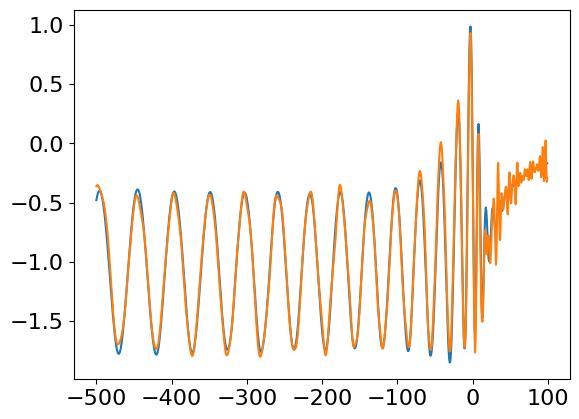

In [1644]:
plt.plot(x, training[worst_error_idx])
plt.plot(x, np.dot(rb.alpha[:,worst_error_idx], rb.basis))

Text(0.5, 1.0, '692')

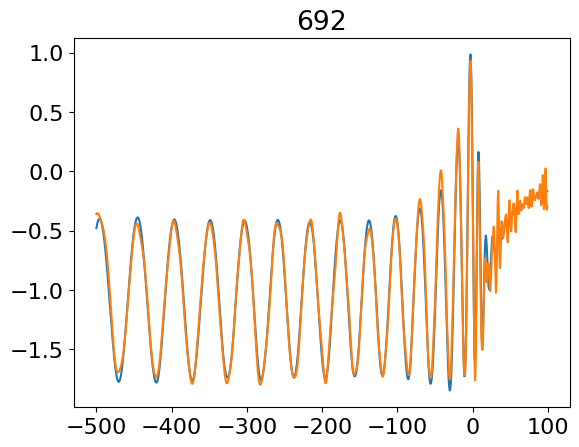

In [1645]:
# idx = np.random.randint(0, len(training))
idx = worst_error_idx
plt.plot(x, training[idx])
plt.plot(x, np.dot(rb.alpha[:,idx], rb.basis))
plt.title(idx)

In [1646]:
# idx = np.random.randint(0, len(training))
idx = worst_error_idx
y0_prime = training[idx]
y1_prime = np.dot(rb.alpha[:,idx], rb.basis)

y0 = this_scaler.inverse_transform(y0_prime[np.newaxis,:])[0]
y1 = this_scaler.inverse_transform(y1_prime[np.newaxis,:])[0]

plt.plot(x, y0)
plt.plot(x, y1)

plt.title(idx)

Text(0.5, 1.0, '692')

Text(0.5, 1.0, '692')

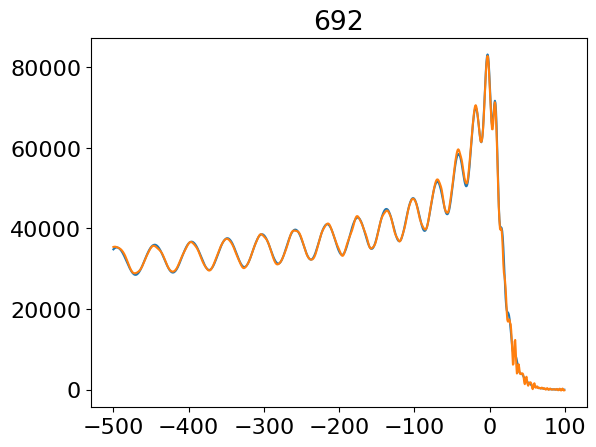

In [1647]:
# idx = np.random.randint(0, len(training))
idx = worst_error_idx

y0_prime = training[idx]
y1_prime = np.dot(rb.alpha[:,idx], rb.basis)

y0 = this_scaler.inverse_transform(y0_prime[np.newaxis,:])[0]
y1 = this_scaler.inverse_transform(y1_prime[np.newaxis,:])[0]

plt.plot(x, y0)
plt.plot(x, y1)

plt.title(idx)

In [1648]:
# idx = np.random.randint(0, len(training))
idx = worst_error_idx

y0_prime = training[idx]
y1_prime = np.dot(rb.alpha[:,idx], rb.basis)

y0 = this_scaler.inverse_transform(y0_prime[np.newaxis,:])[0]
y1 = this_scaler.inverse_transform(y1_prime[np.newaxis,:])[0]

plt.plot(x, y0)
plt.plot(x, y1)

plt.xlim(-100, 100)
plt.title(idx)
plt.yscale('log')